![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.



Dataset
Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

Required Files given in below link.

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Load Data (3 Marks)


In [2]:
import os; 
os.chdir('drive/My Drive/AIML/Sarcasm Detection/')

In [4]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [5]:
data = pd.read_json('./Data/Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 26709 rows and 3 columns. Here are the first five rows of the data...


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# Drop article_link from dataset.

In [6]:
data.drop('article_link', axis = 1, inplace = True)

In [7]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


# Data Preprocessing




*   Converting to lower case
*   Avoid any capital cases
*   Removing punctuations

In [8]:
print('--'*30); print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

------------------------------------------------------------
Converting headlines to lower case
Removing multiple spaces between words


## Get length of each headline and add a column for that (3 Marks)
​

In [9]:
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

Minimum line length: 7
Maximum line length: 254
Line with maximum length: maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, and foreign journalist, dead at 86


## Initialize parameter values

*   Set values for max_features, maxlen, & embedding_size
*   max_features: Number of words to take from tokenizer(most frequent words)
*   maxlen: Maximum length of each sentence to be limited to 25
*   embedding_size: size of embedding vector

In [10]:
max_features = 10000
maxlen = 25
embedding_size = 200

# Apply tensorflow.keras Tokenizer and get indices for words (3 Marks)

*   Initialize Tokenizer object with number of words as 10000
*   Fit the tokenizer object on headline column
*   Convert the text to sequence






In [11]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))
X = tokenizer.texts_to_sequences(data['cleaned_headline'])


# Pad sequences (3 Marks)

*   Pad each example with a maximum length
*   Convert target column into numpy array




In [12]:
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 26709
Number of Labels: 26709

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  307  678 3336 2297   47  381 2575    5 2576 8433]

Label of the first headline: 0


# Vocab mapping

*   There is no word for 0th index




In [13]:
w2i = tokenizer.word_index
vocab_size = len(w2i)
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 29656


# Set number of words

*   Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [14]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

29657


## Load Glove Word Embeddings (3 Marks)

In [15]:

glove_file = './Data/glove.6B.zip'
#from zipfile import ZipFile
#with ZipFile(glove_file, 'r') as z:
#  z.extractall()

## Create embedding matrix

In [23]:
EMBEDDING_FILE = './Data/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

# Define model (5 Marks)

*   Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. In the end add a final dense layer with sigmoid activation for binary classification

In [24]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 21367
Number of columns in training dataset: 25
Number of unique words in training dataset: 9986
------------------------------------------------------------ 
Number of rows in test dataset: 5342
Number of columns in test dataset: 25
Number of unique words in test dataset: 7789


In [25]:

model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))



#Compile the model (3 Marks)

In [39]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
#logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r]

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           5931400   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

## Fit the model (4 Marks)

In [40]:
batch_size = 100
epochs = 6
h= model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/6

Epoch 00001: val_loss improved from inf to 0.45263, saving model to sarcasm_detector.h5
171/171 - 28s - loss: 0.5966 - accuracy: 0.6693 - val_loss: 0.4526 - val_accuracy: 0.7927
Epoch 2/6

Epoch 00002: val_loss improved from 0.45263 to 0.37686, saving model to sarcasm_detector.h5
171/171 - 27s - loss: 0.4386 - accuracy: 0.8030 - val_loss: 0.3769 - val_accuracy: 0.8325
Epoch 3/6

Epoch 00003: val_loss improved from 0.37686 to 0.33989, saving model to sarcasm_detector.h5
171/171 - 27s - loss: 0.3728 - accuracy: 0.8374 - val_loss: 0.3399 - val_accuracy: 0.8479
Epoch 4/6

Epoch 00004: val_loss improved from 0.33989 to 0.32618, saving model to sarcasm_detector.h5
171/171 - 29s - loss: 0.3298 - accuracy: 0.8613 - val_loss: 0.3262 - val_accuracy: 0.8589
Epoch 5/6

Epoch 00005: val_loss improved from 0.32618 to 0.32289, saving model to sarcasm_detector.h5
171/171 - 27s - loss: 0.2997 - accuracy: 0.8759 - val_loss: 0.3229 - val_accuracy: 0.8613
Epoch 6/6

Epoch 00006: val_loss did no

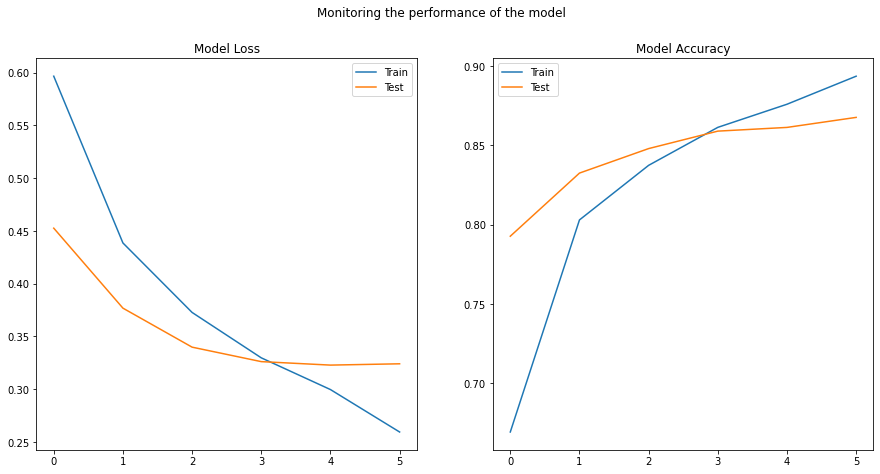

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

## Evaluate the model

In [43]:

loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 86.0


In [44]:

y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      3181
           1       0.80      0.87      0.84      2161

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.87      0.86      0.86      5342



------------------------------------------------------------
Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2720,276
Sarcastic,461,1885


------------------------------------------------------------


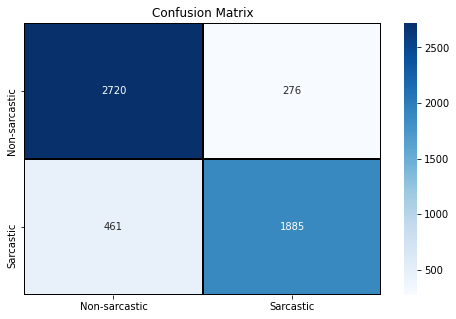

In [45]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

In [49]:
print('Evaluate model on sample sarcastic lines'); print('--'*30)
statements = ['I feel so miserable without you, it\'s almost like having you here.', #Sarcasm
              'If you find me offensive. Then I suggest you quit finding me.', #Sarcasm
              'If I wanted to kill myself I would climb your ego and jump to your IQ.', #Sarcasm
              'Amphibious pitcher makes debut', #Sarcasm
              ]

for statement in statements:
  statement = statement.lower()
  statement = re.sub(' +', ' ', statement)

  headline = tokenizer.texts_to_sequences(statement)
  headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

  sentiment = (model.predict(headline) > 0.5).astype('int32')
  if(np.argmax(sentiment) == 0):
      print(f'`{statement}` is a Non-sarcastic statement.')
  elif (np.argmax(sentiment) == 1):
      print(f'`{statement}` is a Sarcastic statement.')

Evaluate model on sample sarcastic lines
------------------------------------------------------------
`if you find me offensive. then i suggest you quit finding me.` is a Sarcastic statement.
`if i wanted to kill myself i would climb your ego and jump to your iq.` is a Sarcastic statement.
`amphibious pitcher makes debut` is a Sarcastic statement.
